In [ ]:
import torch
import os
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms



In [3]:
# uploader les données
dataset_dir = os.path.join("./tiny-imagenet-200/")
val_dir = os.path.join(dataset_dir, 'val')
img_dir = os.path.join(val_dir, 'images')
fp = open(os.path.join(val_dir, 'val_annotations.txt'), 'r')
data = fp.readlines()
val_img_dict = {}
for line in data:
    words = line.split('\t')
    val_img_dict[words[0]] = words[1]
fp.close()
for img, folder in val_img_dict.items():
    newpath = (os.path.join(img_dir, folder))
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    if os.path.exists(os.path.join(img_dir, img)):
        os.rename(os.path.join(img_dir, img), os.path.join(newpath, img))

train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val', 'images')
test_dir= os.path.join(dataset_dir, 'test')

norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.485, 0.456, 0.406])
train_trans = [transforms.RandomHorizontalFlip(), transforms.ToTensor()]
val_trans = [transforms.ToTensor(), norm]
test_trans = [transforms.ToTensor(), norm]


trainset =ImageFolder(train_dir, transform=transforms.Compose(train_trans + [norm]))
valset =ImageFolder(val_dir, transform=transforms.Compose(val_trans))
testset=ImageFolder(test_dir, transform=transforms.Compose(test_trans))

batch_size = 64

In [4]:
# Charger les données dans le batch


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset , batch_size=batch_size,
                                               shuffle=True, num_workers=2)

testloader=torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)

In [5]:
print(f"Length of Train Data : {len(trainloader)}")
print(f"Length of val Data : {len(valloader)}")
print(f"Length of test Data : {len(testloader)}")


Length of Train Data : 1563
Length of val Data : 157
Length of test Data : 157


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


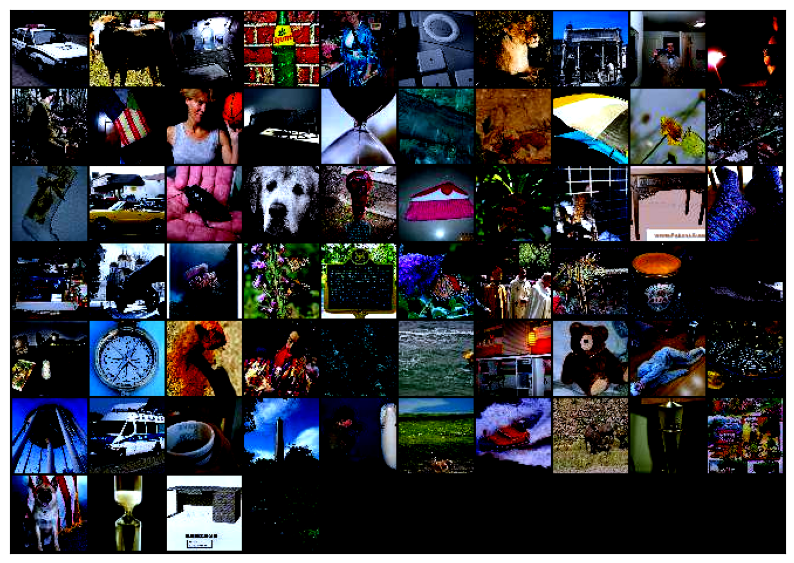

In [6]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (10,10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=10).permute(1,2,0))
        break
        
show_batch(trainloader )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


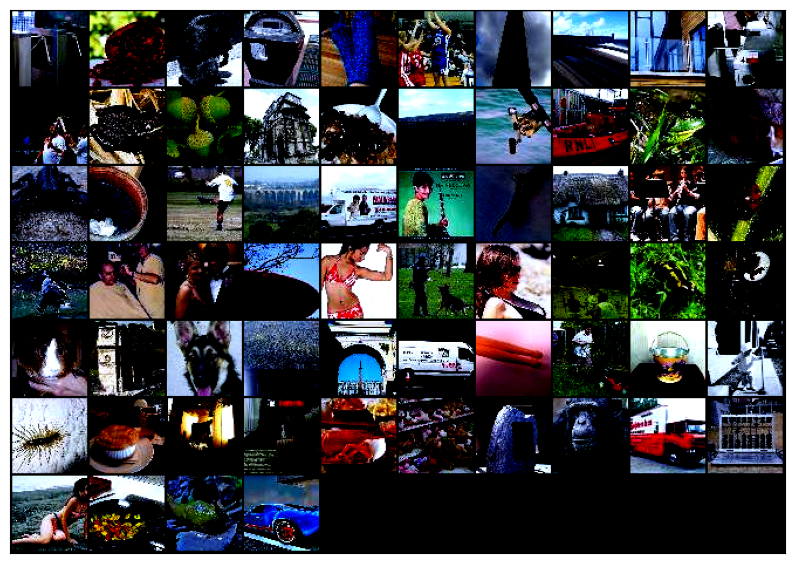

In [7]:
show_batch(valloader )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


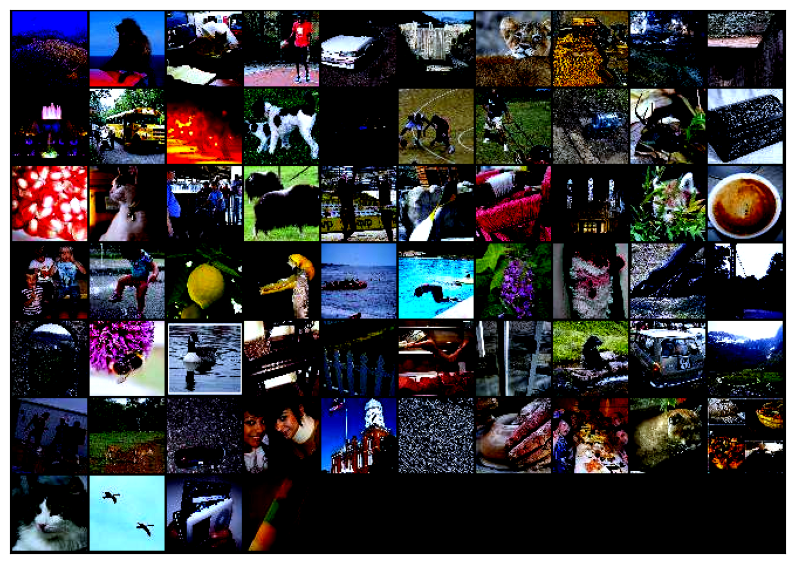

In [8]:
show_batch(testloader)

In [9]:
import torch.nn as nn
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, n_class):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=8, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, n_class),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x


In [10]:
net = Net(200)
print(net)

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(8, 8), stride=(2, 2), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplac

In [11]:
import torch.optim as optim
learning_rate = 1e-5
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(),learning_rate )

In [12]:

for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 450 == 449:    # print every 250 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 450:.3f}')
            running_loss = 0.0

print('Finished Training')





[1,   450] loss: 5.277
[1,   900] loss: 5.045


: 